## Denoising quality control

This script provides visual quality control of denoising protocol. It uses raw and denoised signals extracted from 300 ROIs to create functional connectivity matrices for entire scanning duration (like in resting-state). Used quality measures / visuals:
- edge weight distributions (for each subject and task condition)
- connectivity matrices (for each subject and task condition)
- fc-fd correlation matrices (for each task condition)

> Note: For this script to work it is required to obtain timeseries files from denoised images first. Aggregated timeseries are numpy arrays with of shape $N_{subjects} \times N_{conditions} \times N_{rois} \times N_{timepoints}$. 

---
**Last update**: 25.08.2020

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import combinations

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.plotting import aligned_imshow_cbar

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_networks = os.path.join(path_out, 'networks')
path_timeries = os.path.join(path_out, 'timeseries')
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# Load timeseries
timeseries_denoised_aggregated = np.load(os.path.join(
    path_timeries,
    'timeseries_pipeline-24HMPCSFWM_atlas-300ROI_bold.npy'))
timeseries_raw_aggregated = np.load(os.path.join(
    path_timeries, 
    'timeseries_pipeline-null_atlas-300ROI_bold.npy'))

# Acquisition info
t_r = 2
_, _, n_volumes, n_roi = timeseries_raw_aggregated.shape

In [3]:
# Calculate correlation matrices
corr_mat_raw = np.zeros((n_subjects, n_conditions, n_roi, n_roi))
corr_mat_denoised = np.zeros((n_subjects, n_conditions, n_roi, n_roi))

for sub in range(n_subjects):
    for con in range(n_conditions):
        corr_mat_raw[sub, con] = np.corrcoef(
            timeseries_raw_aggregated[sub, con].T)
        corr_mat_denoised[sub, con] = np.corrcoef(
            timeseries_denoised_aggregated[sub, con].T)
        
# Load confounds summary 
df_exclusion = pd.read_csv(
    os.path.join(path_nistats, 'exclusion/exclusion.csv'),
    index_col=0
)
df_exclusion.head()

# Calculate FC-FD correlations for each connection
corr_fc_fd_raw = np.zeros((n_conditions, n_roi, n_roi))
corr_fc_fd_denoised = np.zeros((n_conditions, n_roi, n_roi))

for con, con_name in enumerate(meta['dim2']):
    
    fd = df_exclusion[f'fd_mean_{con_name}'] 
    
    for i, j in combinations(range(n_roi), 2):
        corr_fc_fd_raw[con, i, j] = np.corrcoef(
            corr_mat_raw[:, con, i, j], fd
            )[0, 1]
        corr_fc_fd_denoised[con, i, j] = np.corrcoef(
            corr_mat_denoised[:, con, i, j], fd
            )[0, 1]   
        
corr_fc_fd_raw += np.transpose(corr_fc_fd_raw, axes=[0, 2, 1])
corr_fc_fd_denoised += np.transpose(corr_fc_fd_denoised, axes=[0, 2, 1])

## Plot denoising QC measures 

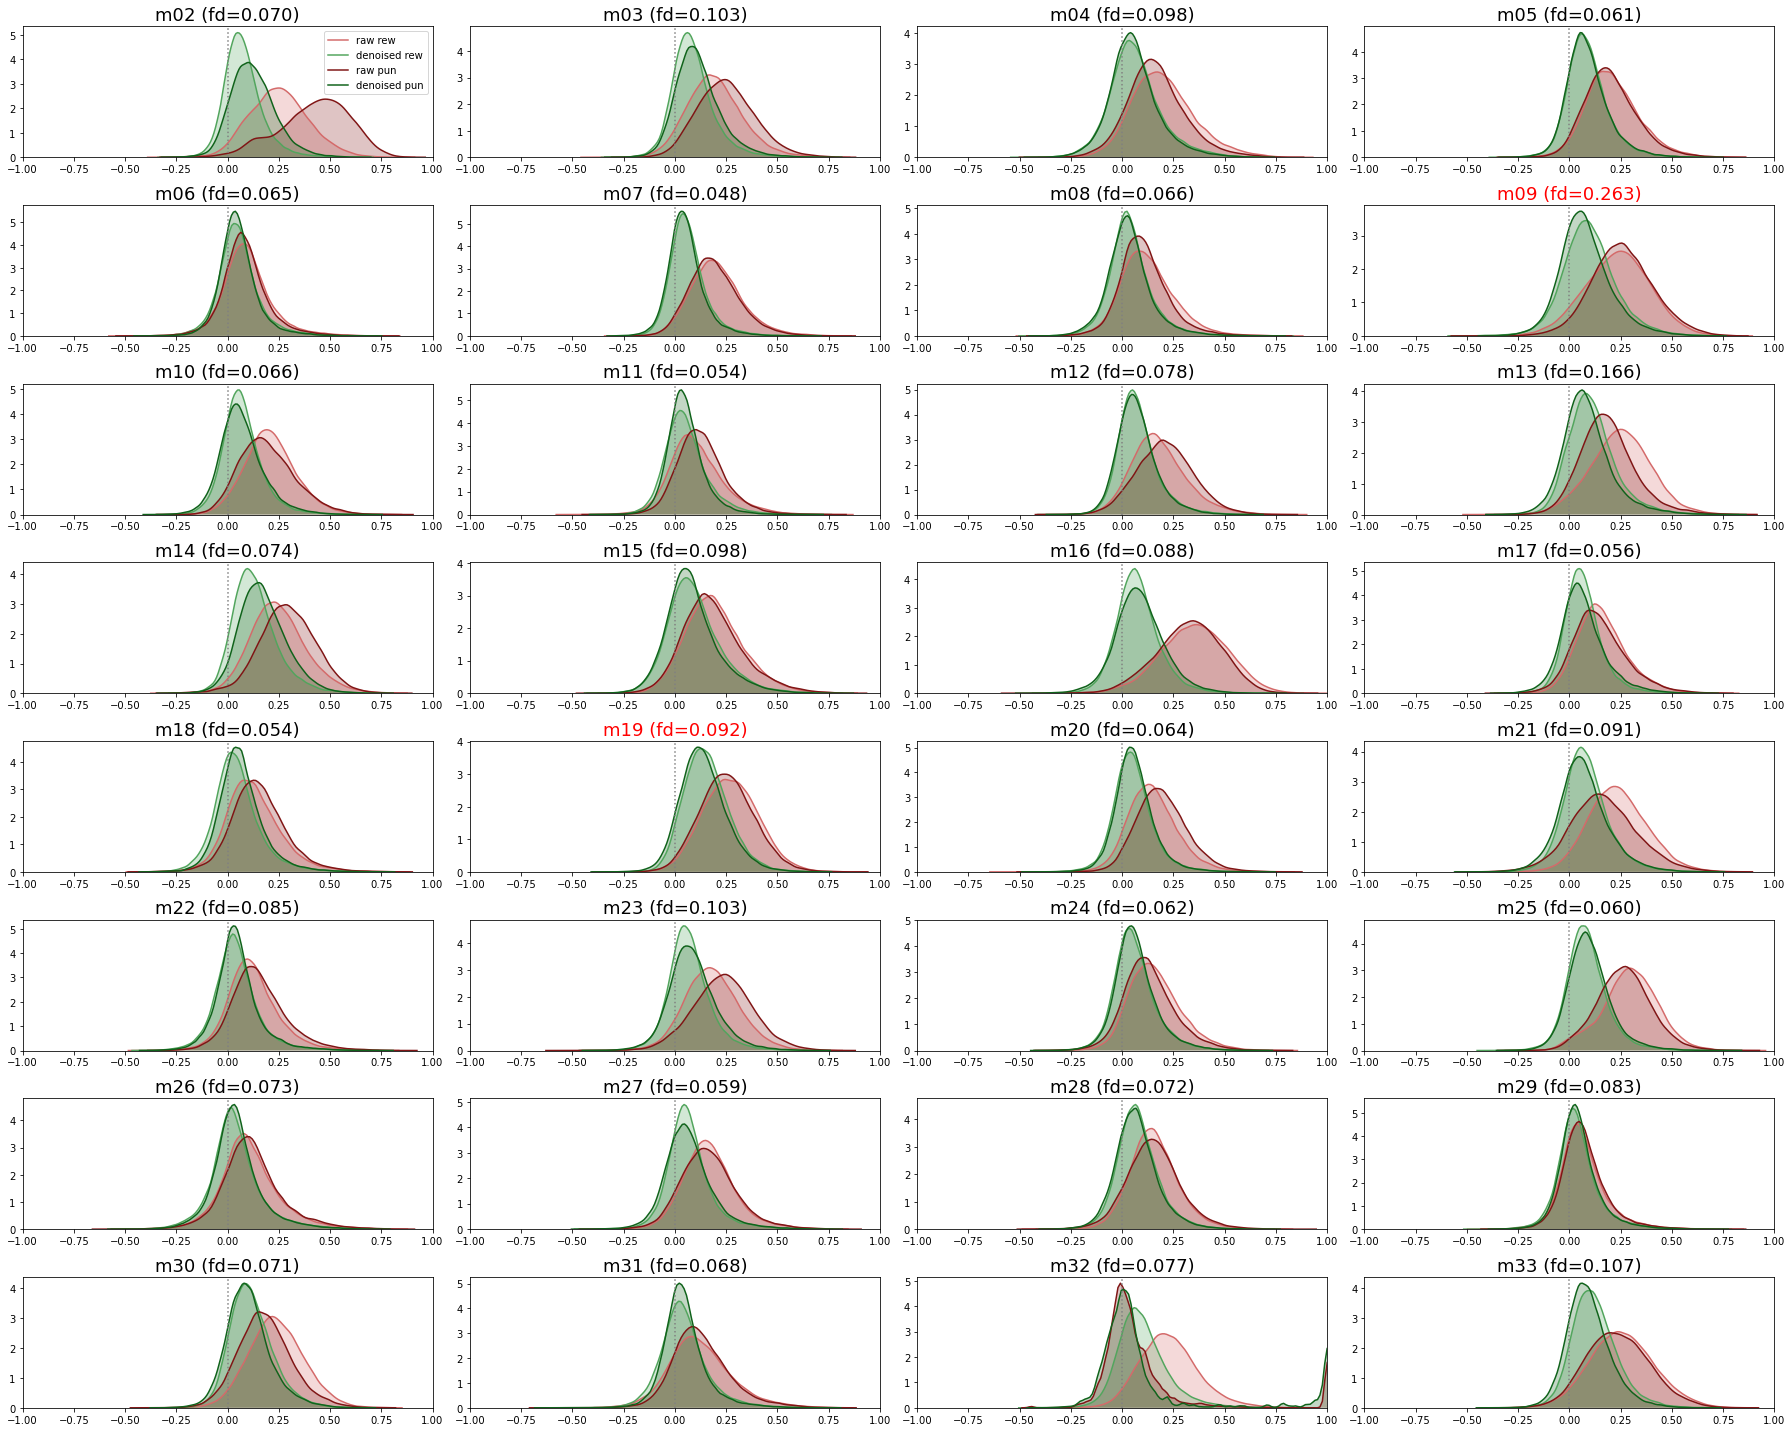

In [4]:
colors_dict = {
    'raw rew': '#D46A6A',
    'raw pun': '#801515',
    'denoised rew': '#52A55D',
    'denoised pun': '#10631B',
}

fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(25, 20), facecolor='w')

for sub, sub_name in enumerate(meta['dim1']):
    
    cur_ax = ax[sub // 4][sub % 4]
    sub_fd = df_exclusion['fd_mean_rew'][sub]
    sub_ok_rew = df_exclusion['ok_rew'][sub]
    
    for con, con_name in enumerate(meta['dim2']):

        sns.kdeplot(
            corr_mat_raw[sub, con][np.triu_indices(n_roi, k=1)], 
            ax=cur_ax, 
            color=colors_dict[f'raw {con_name}'], 
            shade=True,
            label=f'raw {con_name}',
            legend=False
        )
        sns.kdeplot(
            corr_mat_denoised[sub, con][np.triu_indices(n_roi, k=1)], 
            ax=cur_ax, 
            color=colors_dict[f'denoised {con_name}'], 
            shade=True,
            label=f'denoised {con_name}',
            legend=False
        )

    cur_ax.set_title(
        f'{sub_name} (fd={sub_fd:.3f})', 
        fontSize=18, 
        color=('k' if sub_ok_rew else 'r')
    )
    cur_ax.axvline(0, color='gray', linestyle=':')
    cur_ax.set_xlim([-1, 1])
    
ax[0][0].legend()
plt.tight_layout()

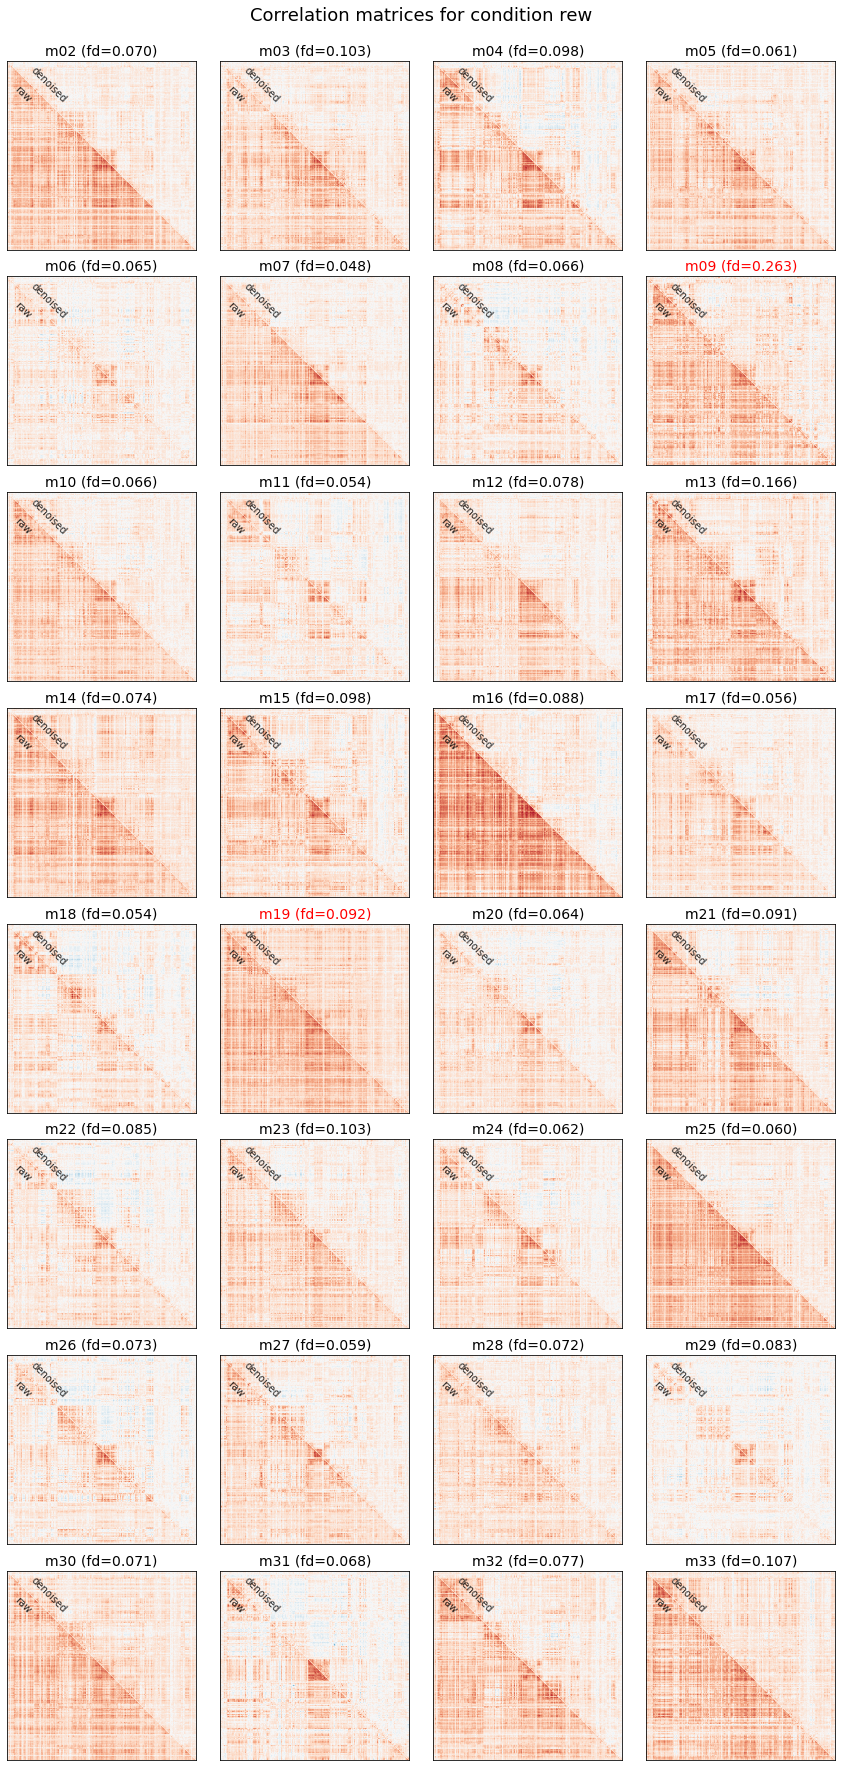

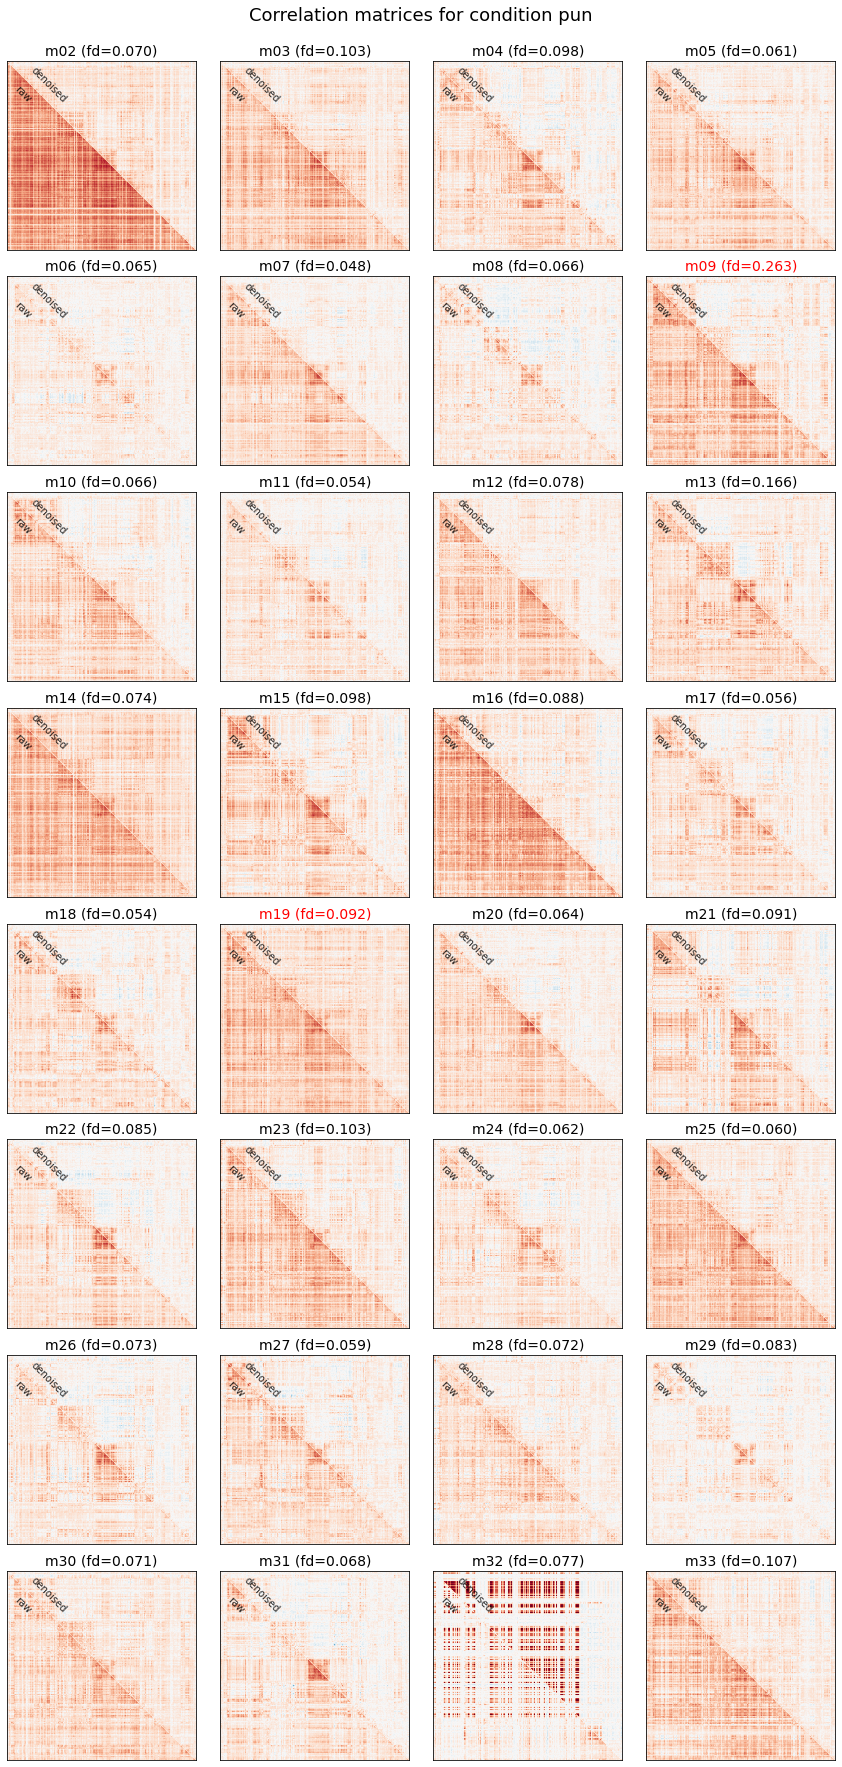

In [5]:
for con, con_name in enumerate(meta['dim2']):

    fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(12, 25), facecolor='w')

    for sub, sub_name in enumerate(meta['dim1']):

        sub_fd = df_exclusion['fd_mean_rew'][sub]
        sub_ok_rew = df_exclusion['ok_rew'][sub]

        A_denoised = corr_mat_denoised[sub, con]
        A_raw = corr_mat_raw[sub, con]
        A = np.triu(A_denoised, 1) + np.tril(A_raw, -1)

        cur_ax = ax[sub // 4][sub % 4]
        cur_im = cur_ax.imshow(A, cmap='RdBu_r', clim=[-1, 1])
        cur_ax.set_title(
            f'{sub_name} (fd={sub_fd:.3f})', 
            fontSize=14, 
            color=('k' if sub_ok_rew else 'r'))
        cur_ax.tick_params(
            which='both', 
            bottom=False, 
            left=False,
            labelbottom=False, 
            labelleft=False)
        cur_ax.annotate('raw', xy=(.08, .78), xycoords='axes fraction', 
                        rotation=-45, ha='center', alpha=0.85)
        cur_ax.annotate('denoised', xy=(.22, .78), xycoords='axes fraction', 
                        rotation=-45, ha='center', alpha=0.85)

    fig.suptitle(f"Correlation matrices for condition {con_name}", fontsize=18)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)

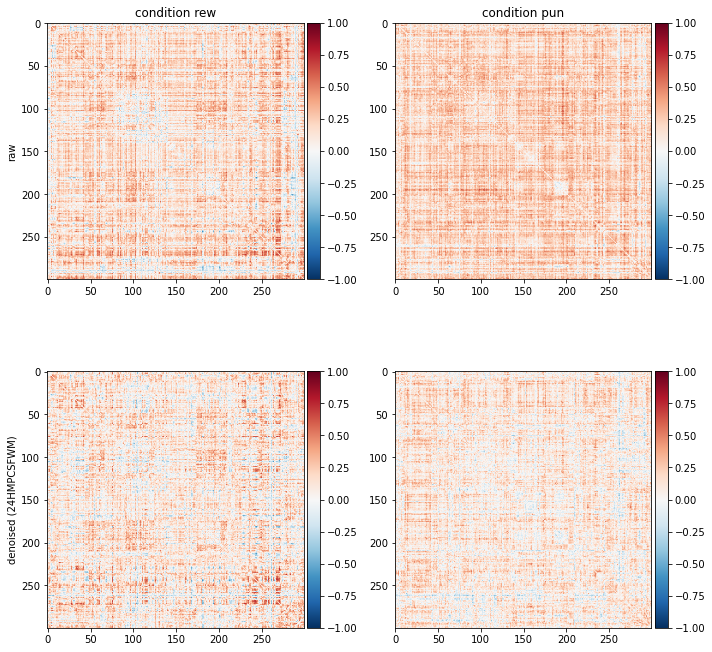

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ims = [[None] * 2, [None] * 2] 

axs[0][0].set_ylabel('raw')
axs[1][0].set_ylabel('denoised (24HMPCSFWM)')

axs[0][0].set_title('condition rew')
axs[0][1].set_title('condition pun')

for con in range(n_conditions):
    ims[0][con] = axs[0][con].imshow(
        corr_fc_fd_raw[con], clim=[-1, 1], cmap='RdBu_r')
    ims[1][con] = axs[1][con].imshow(
        corr_fc_fd_denoised[con], clim=[-1, 1], cmap='RdBu_r')
    
    aligned_imshow_cbar(axs[0][con], ims[0][con])
    aligned_imshow_cbar(axs[1][con], ims[1][con])
    
plt.tight_layout()